# Read in the data set

In [87]:
import pandas as pd
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')   

In [88]:
# data = pd.read_csv("/content/drive/My Drive/PointClickCare/diabetic_data.csv")
data = pd.read_csv("/content/sample_data/diabetic_data.csv")

In [89]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Graphs

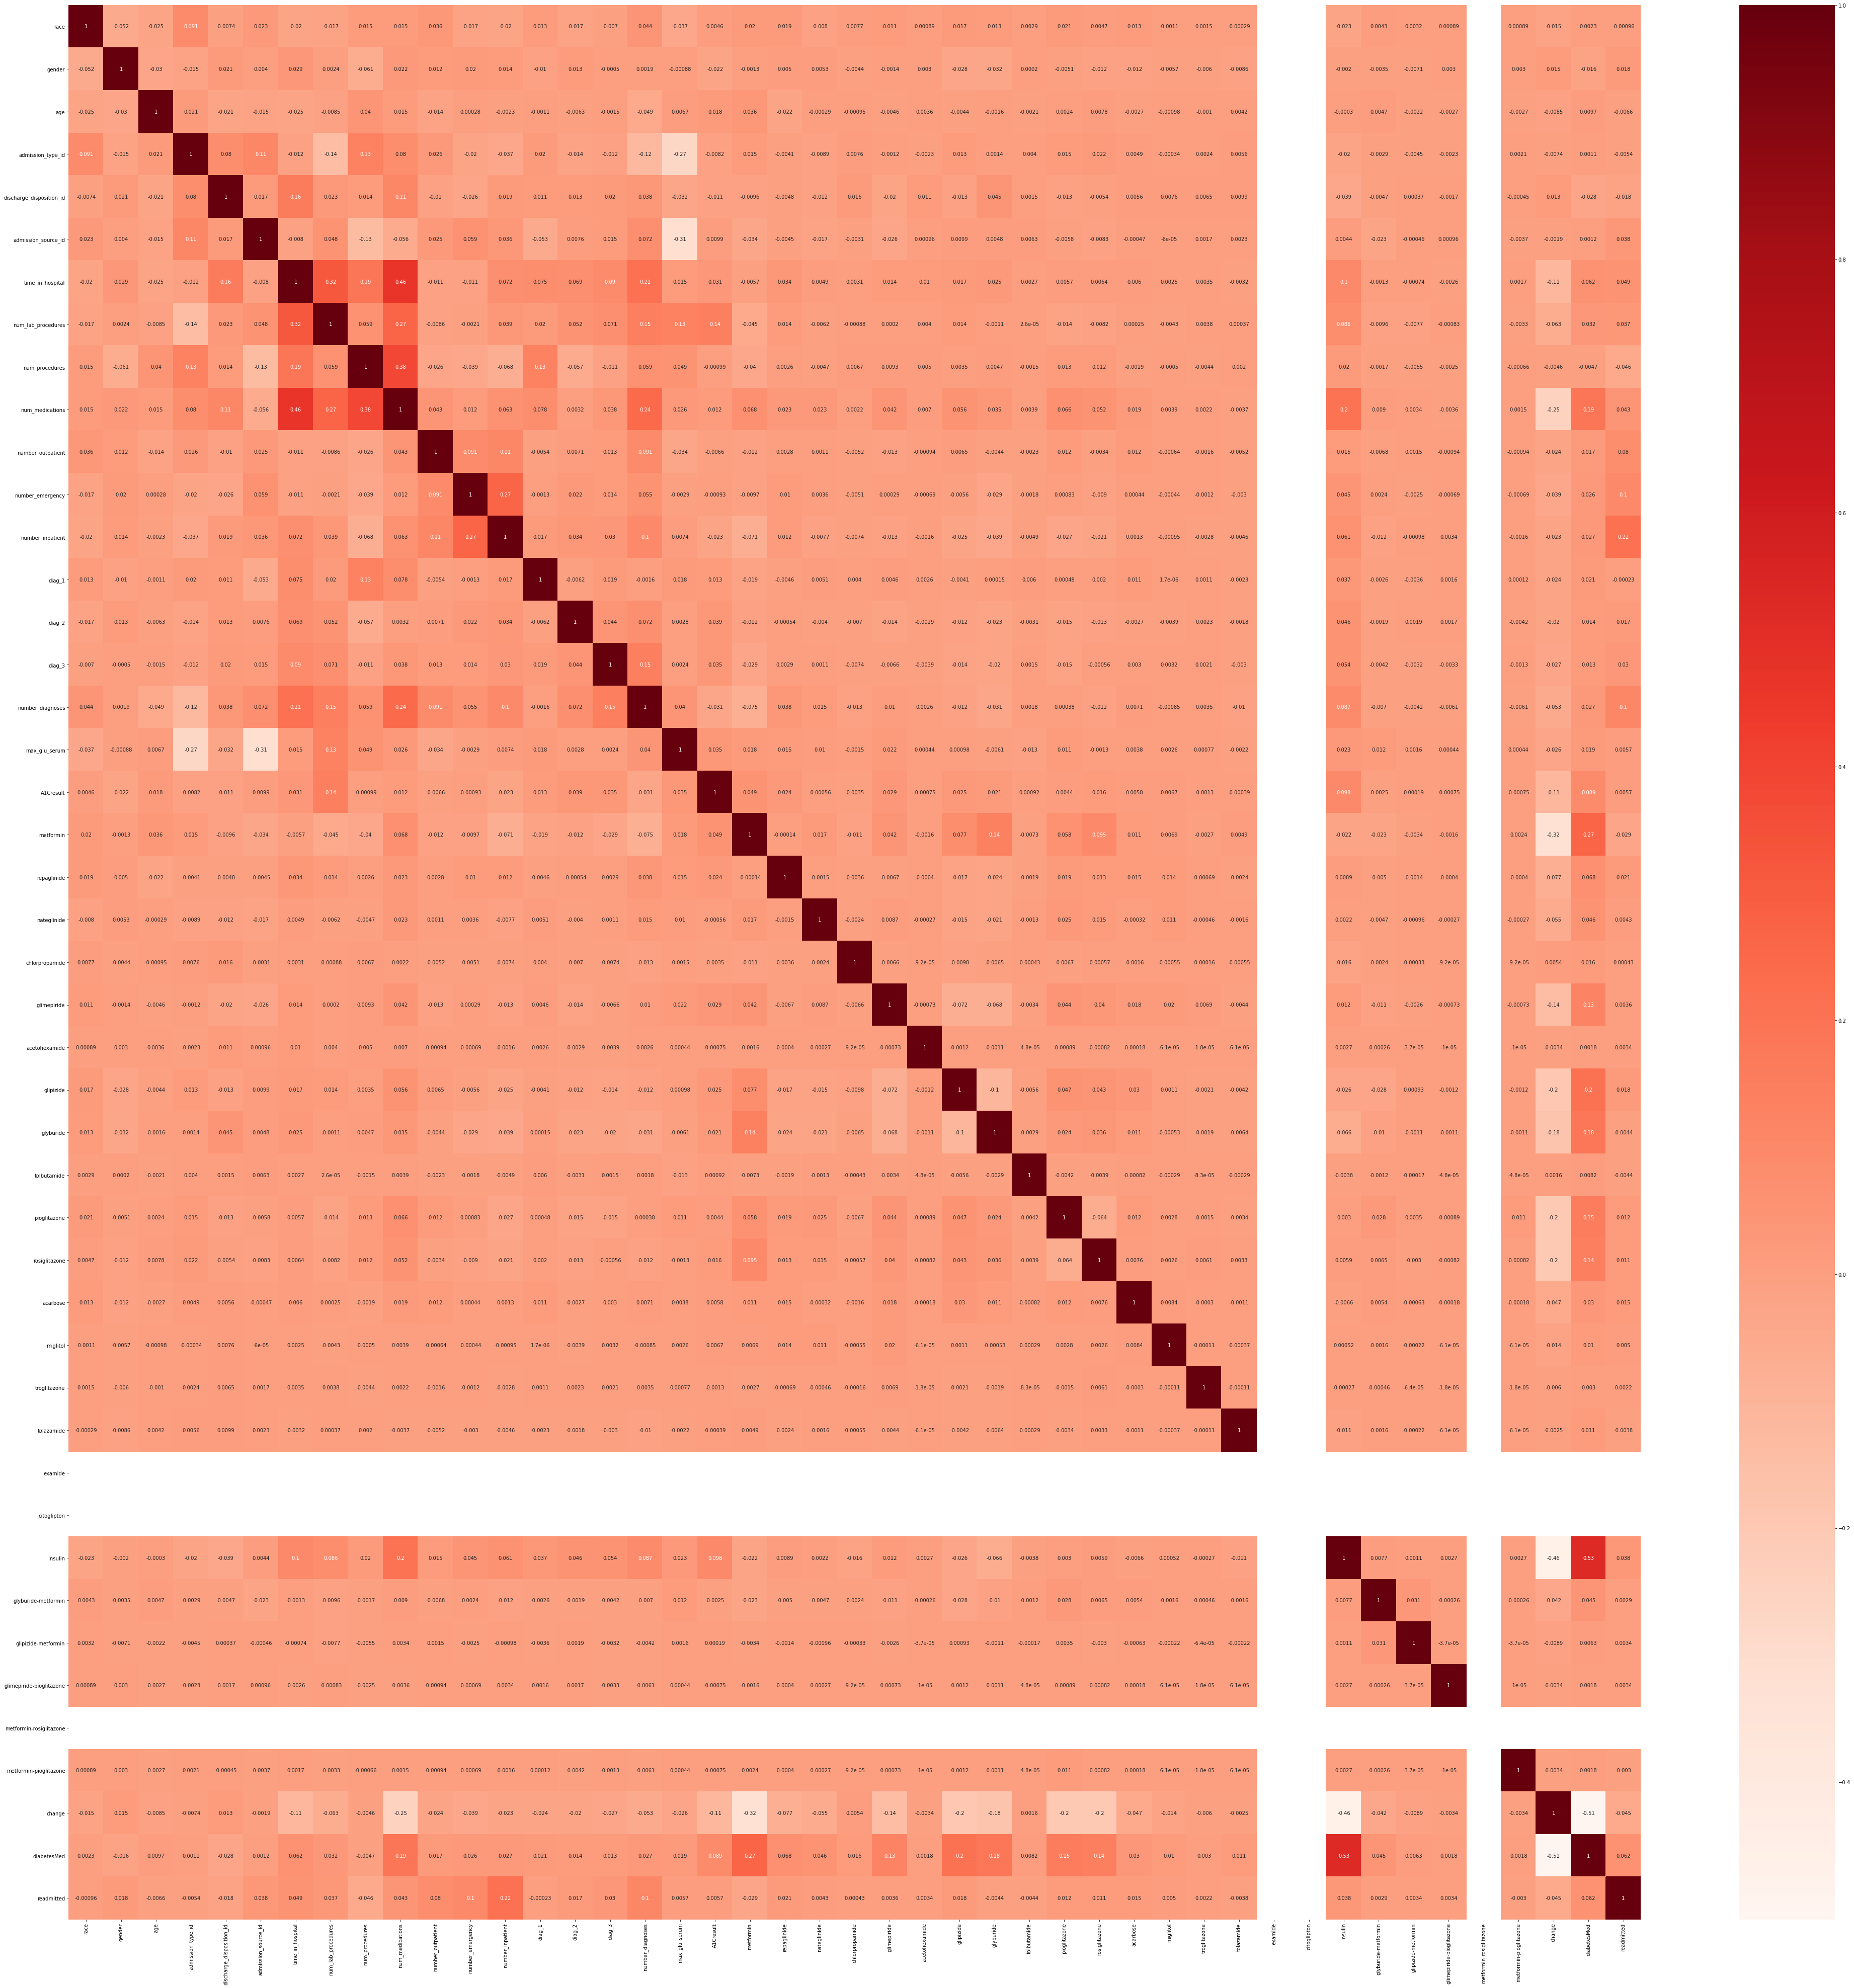

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(70,70))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

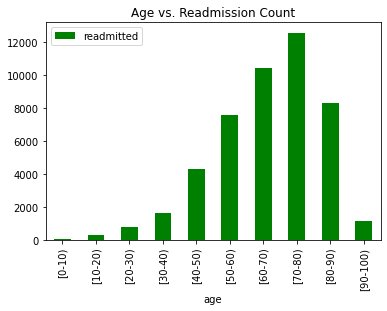

In [85]:
df_age = data[data.readmitted != 'NO'].groupby('age').count()[['readmitted']].reset_index()
df_age.plot(x='age', y='readmitted',kind="bar", color='green')
plt.title('Age vs. Readmission Count')
plt.show()

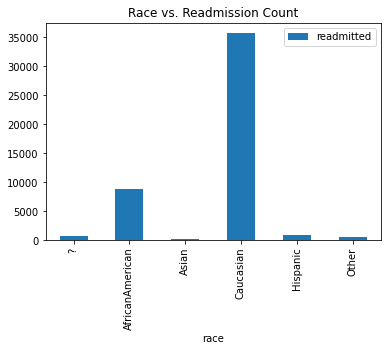

In [81]:
df_race = data[data.readmitted != 'NO'].groupby('race').count()[['readmitted']].reset_index()
df_race.plot(x='race', y='readmitted',kind="bar")
plt.title('Race vs. Readmission Count')
plt.show()

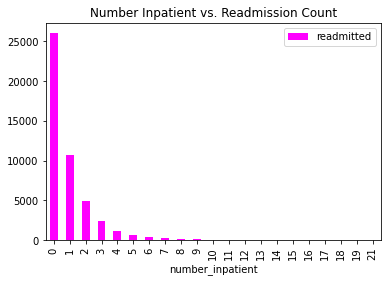

In [86]:
# Number of inpatient visits = Number of inpatient visits of the patient in the year preceding the encounter
df_number_inpatient = data[data.readmitted != 'NO'].groupby('number_inpatient').count()[['readmitted']].reset_index()
df_number_inpatient.plot(x='number_inpatient', y='readmitted',kind="bar", color='magenta')
plt.title('Number Inpatient vs. Readmission Count')
plt.show()

# Drop columns and Normalize values

In [ ]:
data.isin(['?']).sum(axis=0)

In [91]:
#drop columsn with a lot of ?
data.drop(['weight','payer_code','medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True, axis=1)
for col_name in data:
  data = data.loc[data[col_name] != '?'] 

In [ ]:
data.isin(['?']).sum(axis=0)

In [93]:
count_row = data.shape[0]
print(count_row)

98053


In [ ]:
data.head()

In [94]:
# convert readmitted data to be 0 for NO and 1 for <30 or > 30
data["readmitted"].replace({"NO": 0, ">30": 1, "<30": 1}, inplace=True)
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1


In [95]:
# Convert non numerical data to numerical data
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df
data = handle_non_numerical_data(data)
print(data.head())

   race  gender  age  ...  change  diabetesMed  readmitted
1     2       2    9  ...       0            1           1
2     1       2    3  ...       1            1           0
3     2       0    4  ...       0            1           0
4     2       0    5  ...       0            1           0
5     2       0    7  ...       1            1           1

[5 rows x 45 columns]


# Check that data is balance

In [96]:
# Check the distribution of values for readmitted to see if the data is balanced
data['readmitted'].value_counts()

0    52338
1    45715
Name: readmitted, dtype: int64

# Extraction and Scaling

In [97]:
#extracting predictor values & outcome values
x = data.loc[:, data.columns[0:-1]].values
y = data.loc[:, ['readmitted'] ].values
print(x)
print(y)

[[2 2 9 ... 0 0 1]
 [1 2 3 ... 0 1 1]
 [2 0 4 ... 0 0 1]
 ...
 [2 0 8 ... 0 0 1]
 [2 2 0 ... 0 0 1]
 [2 0 8 ... 0 1 0]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [98]:
#create training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)


In [99]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [100]:
y_train=y_train.ravel()
train_data = lightgbm.Dataset(x_train, label=y_train)
test_data = lightgbm.Dataset(x_test, label=y_test)

# Training

In [101]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

clf = lightgbm.train(params, train_data, 100)

In [102]:
#Prediction
y_pred=clf.predict(x_test)

#convert into binary values
for i in range(0,len(y_pred)):
    if y_pred[i]>=0.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0


In [103]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)

cm
accuracy

0.581789997552419

# Save the model

In [104]:
import pickle
# open a file, where you ant to store the data
file = open('diabetes_readmission_model.pkl', 'wb')

# dump information to that file
pickle.dump(clf, file)

# Testing

In [88]:
import sklearn
# sklearn.utils.multiclass.type_of_target(y_test)
y_pred=y_pred.ravel()
sklearn.utils.multiclass.type_of_target(y_pred)

'binary'

In [ ]:
data['readmitted'].value_counts(dropna=False).to_string()


'NO     52338\n>30    34649\n<30    11066'

In [ ]:
data.isin(['?']).sum(axis=0)

In [ ]:
numerical_summary = data.describe()
numerical_summary.transpose()


,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


In [ ]:
numerical_columns = list(numerical_summary.columns)
cat_columns = list(set(data.columns) - set(numerical_columns) )
print(cat_columns)

['max_glu_serum', 'insulin', 'metformin', 'diabetesMed', 'age', 'metformin-pioglitazone', 'readmitted', 'diag_1', 'weight', 'rosiglitazone', 'metformin-rosiglitazone', 'A1Cresult', 'glipizide-metformin', 'change', 'diag_3', 'repaglinide', 'nateglinide', 'examide', 'glimepiride', 'acarbose', 'glimepiride-pioglitazone', 'tolazamide', 'pioglitazone', 'tolbutamide', 'troglitazone', 'race', 'chlorpropamide', 'miglitol', 'payer_code', 'citoglipton', 'gender', 'acetohexamide', 'glyburide', 'diag_2', 'medical_specialty', 'glyburide-metformin', 'glipizide']


In [ ]:
for col in cat_columns:
  print('variable:', col)
  print(data[col].value_counts(dropna=False).to_string())